# API TDD (Test-Driven Development)

The purpose of this notebook is to work out how a user may want to use the library. Code will be written using the desired API/syntax, and then the library will be adjusted. Functions that are not of interest to a typical user will be rendered private (\_privatename single underscore convention).

In [1]:
import os
import sys
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'svg'  # makes inline plot look less blurry

In [3]:
home_path = os.path.abspath(os.path.join('..'))
if home_path not in sys.path:
    sys.path.append(home_path)

In [4]:
tests_path = os.path.abspath(os.path.join('..', 'tests'))
if tests_path not in sys.path:
    sys.path.append(tests_path)

## Scenario: user wants to plot a spectrum for an ABX 3-spin system.


Setup: user has v/J data as python lists

In [5]:
# load the parameters used by Rioux for his example at:
# http://www.users.csbsju.edu/~frioux/nmr/ABC-NMR-Tensor.pdf
from simulation_data import rioux

In [6]:
v, J = rioux()
print(v)
print(J)

[430. 265. 300.]
[[ 0.   7.  15. ]
 [ 7.   0.   1.5]
 [15.   1.5  0. ]]


In [7]:
from nmrtools import qm

In [8]:
spectrum = qm.spectrum(v, J, normalize=True)

In [9]:
from nmrtools.nmrplot import mplplot

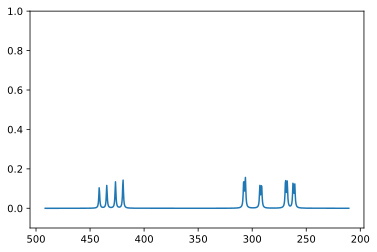

In [10]:
mplplot(spectrum)

In [11]:
spectrum

[(260.66152857482973, 0.2301124913178783),
 (262.18930344673686, 0.2487606172641341),
 (267.62991550888137, 0.24855578963215696),
 (269.1576903807885, 0.2725641675868917),
 (291.3191136690316, 0.22882003310401844),
 (292.84688854093866, 0.21381231157251776),
 (306.32295186307283, 0.29251680284079623),
 (307.85072673497996, 0.26486802047130636),
 (419.5193577561387, 0.29107244545559474),
 (426.4877446901903, 0.26629867696733883),
 (434.52319595017997, 0.2300458619680737),
 (441.4915828842316, 0.21257278181929298)]

In [12]:
# aside: checking the type of new_compile_spectrum
from nmrtools.qm import new_compile_spectrum, intensity_and_energy, hamiltonian_sparse


In [13]:
I, E = intensity_and_energy(hamiltonian_sparse(*rioux()).todense(), 3)
print(type(I))
print(type(E))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [14]:
I

array([[0.00000000e+00, 9.20443866e-01, 9.15274067e-01, 1.16428207e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.20443866e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.55243579e-01, 1.06518765e+00, 1.26375317e-05, 0.00000000e+00],
       [9.15274067e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.95035875e-01, 6.08415874e-05, 9.20177350e-01, 0.00000000e+00],
       [1.16428207e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.03839387e-06, 9.94216570e-01, 1.17005946e+00, 0.00000000e+00],
       [0.00000000e+00, 8.55243579e-01, 9.95035875e-01, 6.03839387e-06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.50285493e-01],
       [0.00000000e+00, 1.06518765e+00, 6.08415874e-05, 9.94216570e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.05946506e+00],
       [0.00000000e+00, 1.26375317e-05, 9.20177350e-01, 1.17005946e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.

In [15]:
E

array([-491.625     , -230.96347143, -200.30588633,  -72.10564224,
         61.88341712,  195.52427327,  234.21730962,  503.375     ])

In [16]:
spectrum_test = new_compile_spectrum(I, E)
type(spectrum_test)

numpy.ndarray

In [17]:
spectrum_test

array([[260.66152857,   0.92044387],
       [291.31911367,   0.91527407],
       [419.51935776,   1.16428207],
       [292.84688854,   0.85524358],
       [426.48774469,   1.06518765],
       [262.18930345,   0.99503588],
       [434.52319595,   0.92017735],
       [267.62991551,   0.99421657],
       [306.32295186,   1.17005946],
       [441.49158288,   0.85028549],
       [307.85072673,   1.05946506],
       [269.15769038,   1.09024945]])

__How does a user want their spectrum?__ Currently a list of tuples is provided. Some routines may be better implemented if the spectrum remained a numpy array. e.g. compile_spectrum provides a 2D array of `[[frequency, intensity]...]`. normalize_spectrum then separates into frequency and intensity arrays, processes the latter, then puts them back together.

Need to survey how the most common plotting libraries handle x, y data. Two scenarios: lineshape, and stick.

In [18]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
x, y = np.random.random((2, 20))
print(x)
print(y)

[0.40040282 0.05643394 0.20857133 0.58543667 0.26084763 0.22263318
 0.19148373 0.00895906 0.43185554 0.90750178 0.43425567 0.9861423
 0.16223307 0.43178877 0.75849161 0.40245669 0.39330092 0.52662598
 0.83739178 0.91984435]
[0.61443692 0.53631367 0.27817887 0.98882251 0.71949435 0.24081938
 0.75554793 0.67644398 0.94799164 0.25394778 0.18730673 0.31557661
 0.61468981 0.9291815  0.84582769 0.17619578 0.30313249 0.73534795
 0.99277994 0.36279858]


In [31]:
x, y = spectrum_test.T

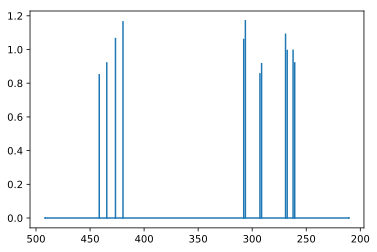

In [30]:
fig, ax = plt.subplots()
l_limit = x.min() - 50
r_limit = x.max() + 50
x = np.append(x, [l_limit, r_limit])
y = np.append(y, [0.001, 0.001])
ax.stem(x, y, markerfmt=' ', basefmt='C0-')
ax.invert_xaxis()
plt.show()

In [24]:
from nmrtools.nmrplot import mplplot_stick

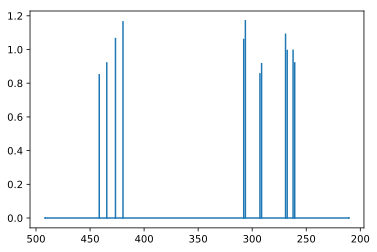

In [32]:
mplplot_stick(x, y)

In [27]:
x

array([0.40040282, 0.05643394, 0.20857133, 0.58543667, 0.26084763,
       0.22263318, 0.19148373, 0.00895906, 0.43185554, 0.90750178,
       0.43425567, 0.9861423 , 0.16223307, 0.43178877, 0.75849161,
       0.40245669, 0.39330092, 0.52662598, 0.83739178, 0.91984435])

In [28]:
y

array([0.61443692, 0.53631367, 0.27817887, 0.98882251, 0.71949435,
       0.24081938, 0.75554793, 0.67644398, 0.94799164, 0.25394778,
       0.18730673, 0.31557661, 0.61468981, 0.9291815 , 0.84582769,
       0.17619578, 0.30313249, 0.73534795, 0.99277994, 0.36279858])